# Introduction to Open AI Gym 
[OpenAI Gym](https://gym.openai.com/) aims to provide an easy-to-setup general-intelligence benchmark with a wide variety of different environments. The goal is to standardize how environments are defined in AI research publications so that published research becomes more easily reproducible. The project claims to provide the user with a simple interface. 

### Looking at Gym Environments

The centerpiece of Gym is the environment, which defines the "game" in which your reinforcement algorithm will compete.  An environment does not need to be a game; however, it describes the following game-like features:
* **action space**: What actions can we take on the environment, at each step/episode, to alter the environment.
* **observation space**: What is the current state of the portion of the environment that we can observe. Usually, we can see the entire environment.

Before we begin to look at Gym, it is essential to understand some of the terminology used by this library.

* **Agent** - The machine learning program or model that controls the actions.
Step - One round of issuing actions that affect the observation space.
* **Episode** - A collection of steps that terminates when the agent fails to meet the environment's objective, or the episode reaches the maximum number of allowed steps.
* **Render** - Gym can render one frame for display after each episode.
* **Reward** - A positive reinforcement that can occur at the end of each episode, after the agent acts.
* **Nondeterministic** - For some environments, randomness is a factor in deciding what effects actions have on reward and changes to the observation space.

It is important to note that many of the gym environments specify that they are not nondeterministic even though they make use of random numbers to process actions. It is generally agreed upon (based on the gym GitHub issue tracker) that nondeterministic property means that a deterministic environment will still behave randomly even when given consistent seed value. The seed method of an environment can be used by the program to seed the random number generator for the environment.

Altough Google Colab does not allow us to render each environment, you can take a look at the environment at [OpenAI Gym Environments](https://gym.openai.com/envs/#classic_control)

The Gym library allows us to query some of these attributes from environments. We will begin by looking at the FrozenLake-v0 environment. The RL agent will control the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

In [1]:
import gym
import time
import numpy
import matplotlib.pyplot as plt

def query_environment(name):
  env = gym.make(name)
  spec = gym.spec(name)
  print(f"Action Space: {env.action_space}")
  print(f"Observation Space: {env.observation_space}")
  print(f"Max Episode Steps: {spec.max_episode_steps}")
  print(f"Nondeterministic: {spec.nondeterministic}")
  print(f"Reward Range: {env.reward_range}")
  print(f"Reward Threshold: {spec.reward_threshold}")

query_environment("FrozenLake-v1")

Action Space: Discrete(4)
Observation Space: Discrete(16)
Max Episode Steps: 100
Nondeterministic: False
Reward Range: (0, 1)
Reward Threshold: 0.7


The agent moves through a $4 \times 4$ gridworld, with states numbered as follows:
```
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
```
Each state can be categorized into the following states
```
SFFF       (S: starting point, safe)
FHFH       (F: frozen surface, safe)
FFFH       (H: hole, fall to your doom)
HFFG       (G: goal, where the frisbee is located)
```
The agent has 4 potential actions:
```
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
```

Thus, $\mathcal{S}^+ = \{0, 1, \ldots, 15\}$, and $\mathcal{A} = \{0, 1, 2, 3\}$.  

# Value Iteration

Now we are going to instance a Fronzen lake environment, and try to implement Value itertaions. 

**You need to implement the code at where is labeled ``TODO:''**

In [2]:
def valueIteration(env, gamma=1.0, iteration=10000, eps=1e-20):
    value = numpy.zeros(env.nS)

    # Start Iteration
    for i in range(iteration):
        previous_value = numpy.copy(value)
        for state in range(env.nS):
            Q = []
            for action in range(env.nA):
                outcomes  = []

                # TODO: Loop through all outcomes of performing that action and calculate the Q values
                for probability, nextstate, reward, done in env.P[state][action]:
                    outcomes.append(probability * (reward + gamma * (value[nextstate])))

                Q.append(sum(outcomes))

            # TODO: Calculate the value function
            value[state] = max(Q)

        if(numpy.sum(numpy.fabs(previous_value - value)) <= eps):
            return value

    print("Iterated over %d Iterations and couldn't converge"%(iteration))
    return value

In [3]:
def calculatePolicy(env, v, gamma=1.0):
    policy = numpy.zeros(env.nS)
    for state in range(env.nS):
        Q = [] 
        for action in range(env.nA):

            # Reset all outcomes of this particular action
                outcomes  = []

                # TODO: Loop through all outcomes of performing that action and calculate the Q values
                for probability, nextstate, reward, done in env.P[state][action]:
                    outcomes.append(probability * (reward + gamma * (v[nextstate])))

                Q.append(sum(outcomes))

        # TODO: extract policy 
        policy[state] = Q.index(max(Q))

    # Step 9: Return policy
    return policy

In [15]:
def evaluatePolicyOnce(env, policy, gamma=1.0, eps=1e-20):
    totalreward = 0
    step = 0
    start = env.reset()

    while True:
        action = policy[start]

        start, reward, done, _ = env.step(action)

        # TODO: Calculate the total reward with the given discount factor
        totalreward += reward * (gamma ** (step-1))
        step += 1

        if done:
            break
    return totalreward

def evaluatePolicy(env, policy, gamma=1.0, iteration=100, render=False, eps=1e-20):
    scores = [
    evaluatePolicyOnce(env, policy, gamma, eps)
        for _ in range(iteration)
    ]

    return numpy.mean(scores)

In [16]:
def ValueIterator(env, gamma=1.0, improvementIterations=1000, evaluationIterations=100, eps=1e-20):
    optimalValue = valueIteration(env, gamma, improvementIterations, eps)
    policy = calculatePolicy(env, optimalValue, gamma)
    score = evaluatePolicy(env, policy, gamma, evaluationIterations, eps)
    print('Score obtained', score)
    print('Best score = %0.2f.'%(numpy.max(score)))

In [17]:
gamma = 1.0
game = 'FrozenLake-v1'
improvementIterations = 10000
evaluationIterations = 100
eps = 1e-20
numpy.random.seed(0)
env = gym.make(game)
env.seed(0)

env = gym.make(game).env
ValueIterator(env=env, gamma=gamma, evaluationIterations=evaluationIterations, improvementIterations=improvementIterations, eps=eps)

Score obtained 0.83
Best score = 0.83.


We also provide the following code to visualize your calculated value function.

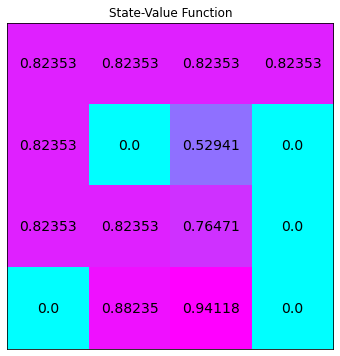

In [7]:
def plot_values(V):
    # reshape value function
    V_sq = numpy.reshape(V, (4,4))

    # plot the state-value function
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    im = ax.imshow(V_sq, cmap='cool')
    for (j,i),label in numpy.ndenumerate(V_sq):
        ax.text(i, j, numpy.round(label, 5), ha='center', va='center', fontsize=14)
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.title('State-Value Function')
    plt.show()

optimalValue = valueIteration(env, gamma, improvementIterations, eps)
plot_values(optimalValue)

# Policy Iteration

With the Frozen Lake environment, we are also going to try out the policy iteration method. 

**Again, please implement the code labeled #TODO**

In [8]:
"""Given a policy, extract its corresponding value function"""
def get_value_function(env, policy, gamma, eps=1e-20):

    value = numpy.zeros(env.nS)

    while True:
        previous_value = numpy.copy(value)
        for state in range(policy.size):
            outcomes  = []

            # TODO: Extract the action from policy
            action = policy[state]

            for probability, next_state, reward, is_done in env.P[state][action]:
                # TODO: Get all outcomes of that action
                outcomes.append(probability * (reward + gamma * value[next_state]))

            # TODO: Extract the value function
            value[state] = sum(outcomes)

        if numpy.sum(numpy.fabs(previous_value - value)) <= eps:
            return value

    return value

In [9]:
def policyIteration(env, gamma=1.0, improvementIterations=1000, eps=1e-20):

    # Declare a random policy
    policy = numpy.random.choice(env.nA, size=(env.nS))

    for i in range(improvementIterations):

        # TODO: calculate the value function with the previous policy, 
        #  then use this value function to iterate for an improved pocliy 
        #  Hint: you've already implemented how to use a value function 
        #  to calculate a policy in calculatePolicy
        newPolicy = numpy.zeros(env.nS)
        value = get_value_function(env, policy, gamma, eps)
        for state in range(env.nS):
            Q = []
            for action in range(env.nA):
                outcomes = []
                for probability, next_state, reward, _ in env.P[state][action]:
                    outcomes.append(probability * (reward + gamma * value[next_state]))
                Q.append(sum(outcomes))
            newPolicy[state] = Q.index(max(Q))

        # If converged
        if(numpy.all(policy == newPolicy)):
            return policy
        policy = newPolicy

    print("Iterated over %d Iterations and couldn't converge"%(improvementIterations))
    return policy

In [10]:
gamma = 1.0
improvementIterations = 10000
evaluationIterations = 100
eps = 1e-20
numpy.random.seed(0)
env = gym.make(game)
env.seed(0)

def PolicyIterator(env, gamma=1.0, improvementIterations=1000, eps=1e-20, evaluationIterations=100):
    optimalPolicy = policyIteration(env=env, gamma=gamma, improvementIterations=improvementIterations, eps=eps)
    startTime = time.time()
    policy_score = evaluatePolicy(env, policy=optimalPolicy, gamma=gamma, iteration=evaluationIterations, render=False, eps=eps)
    endTime = time.time()
    print('Best score = %0.2f. Time taken = %4.4f seconds'%(numpy.max(policy_score), endTime - startTime))

We can also visualize the value function with respect to the policy.

Best score = 0.82. Time taken = 0.0379 seconds


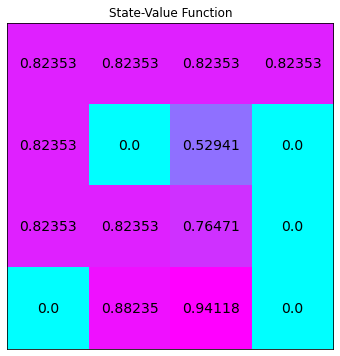

In [18]:
PolicyIterator(env, gamma=1, improvementIterations=10000, eps=1e-20, evaluationIterations=100)

optimalPolicy = policyIteration(env=env, gamma=gamma, improvementIterations=improvementIterations, eps=eps)
PolicyValue = get_value_function(env=env, policy=optimalPolicy, gamma=gamma, eps=eps)

plot_values(PolicyValue)

#Comparing the value and policy iteration methods.

Lastly, please try to play around with the FrozenLake environment with different configurations (gamma, improvement/evaluation iterations, random seed)and with value and policy iteration. Please try your best to get a policy with score as high as possible (though your grades will not be affected by this score). Repeat each experiment with 5 different random seed, then report the highest score you've achieved across the 5 repeats with 1 standard deviation and write (a few sentence) to compare the two iteration methods.